In [80]:
import Pkg
Pkg.add("Flux")
Pkg.add("MLBase")
using Flux
using Flux: mse, throttle, params, train!
using CSV
using DataFrames
using Statistics
using Plots
using MLBase


   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [81]:
using CSV, DataFrames, Flux

# Load data
data = CSV.File("71-80.csv") |> DataFrame

# Function to normalize data
function normalize(df::AbstractDataFrame, cols::Vector{<:AbstractString})
    means = mean.(eachcol(df[:, cols]))
    stds = std.(eachcol(df[:, cols]))

    # Convert means and stds to the appropriate shape for broadcasting
    means_matrix = repeat(means', nrow(df), 1)
    stds_matrix = repeat(stds', nrow(df), 1)

    return (df[:, cols] .- means_matrix) ./ stds_matrix
end

# Add the ratio column
data[:, "ratio"] = data[:, "cit_2022"] ./ data[:, "cit_2021"]

# Classify the ratio
data[:, "category"] = ifelse.(data[:, "ratio"] .< 1.05, 1, ifelse.(data[:, "ratio"] .<= 1.15, 2, 3))
print(data[!, "category"])


[1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 3, 1, 1, 3, 2, 3, 3, 2, 1, 1, 1, 2, 3, 2, 1, 1, 3, 1, 2, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 2, 3, 1, 1, 1, 3, 3, 3, 3, 2, 1, 1, 3, 1, 3, 3, 1, 3, 2, 1, 2, 3, 3, 3, 1, 3, 1, 1, 3, 2, 1, 3, 3, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 2, 1, 1, 1, 1, 3]

In [82]:
# One-hot encode the categories
onehot_encoded = Flux.onehotbatch(data[:, "category"], 1:3)

# Convert the one-hot encoded data to a regular matrix
onehot_as_matrix = Int.(onehot_encoded)

# Add the one-hot encoded columns to the DataFrame
for i in 1:size(onehot_as_matrix, 1)
    data[!, "category_onehot_$i"] = onehot_as_matrix[i, :]
end
# Normalize citation data
X = normalize(data, ["cit_2017", "cit_2018", "cit_2019", "cit_2020", "cit_2021", "cit_2022"])

# Prepare labels by concatenating the one-hot encoded columns
Y = hcat(data[:, "category_onehot_1"], data[:, "category_onehot_2"], data[:, "category_onehot_3"])

# Split into training and test datasets (80% train, 20% test)
n = size(data, 1)
split = floor(Int, 0.8 * n)
X_train, Y_train = X[1:split, :], Y[1:split, :]
X_test, Y_test = X[split+1:end, :], Y[split+1:end, :]
println(Y_test)

# Transpose your data for Flux
X_train = transpose(Array{Float32}(X_train))
Y_train = transpose(Array{Float32}(Y_train))
X_test = transpose(Array{Float32}(X_test))
Y_test = transpose(Array{Float32}(Y_test))

                


[0 1 0; 0 0 1; 1 0 0; 1 0 0; 1 0 0; 1 0 0; 1 0 0; 1 0 0; 1 0 0; 1 0 0; 0 0 1; 0 0 1; 1 0 0; 1 0 0; 0 1 0; 1 0 0; 1 0 0; 1 0 0; 1 0 0; 0 0 1]


3×20 transpose(::Matrix{Float32}) with eltype Float32:
 0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  0.0  1.0  1.0  1.0  1.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  1.0

In [83]:

# Neural network model
model = Chain(
    Dense(6, 6, relu),
    Dense(6, 3),
    softmax
)

# Loss function
loss(x, y) = Flux.Losses.crossentropy(model(x), y)

# Optimizer
optimizer = ADAM(0.001)





Adam(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [84]:

# Initialize the data loader
data_loader = Flux.DataLoader((X_train, Y_train), batchsize=5, shuffle=true)


training_losses = Float64[]
testing_losses = Float64[]
epochs = 100
for epoch in 1:epochs
    for (x, y) in data_loader
        gs = Flux.gradient(params(model)) do
            loss(x, y)
        end
        Flux.Optimise.update!(optimizer, params(model), gs)
    end
    
    # Calculate and store the training loss for this epoch
    epoch_training_loss = loss(X_train, Y_train)
    push!(training_losses, epoch_training_loss)
    
    # Calculate and store the testing loss for this epoch
    epoch_testing_loss = loss(X_test, Y_test)
    push!(testing_losses, epoch_testing_loss)
    
    println("Epoch: $epoch, Training Loss: $epoch_training_loss, Testing Loss: $epoch_testing_loss")
end



Epoch: 1, Training Loss: 1.3883245, Testing Loss: 1.6753523
Epoch: 2, Training Loss: 1.3371844, Testing Loss: 1.5916202
Epoch: 3, Training Loss: 1.2903819, Testing Loss: 1.5146304
Epoch: 4, Training Loss: 1.2511443, Testing Loss: 1.450494
Epoch: 5, Training Loss: 1.2172278, Testing Loss: 1.398284
Epoch: 6, Training Loss: 1.1888607, Testing Loss: 1.3514265
Epoch: 7, Training Loss: 1.1601052, Testing Loss: 1.3072681
Epoch: 8, Training Loss: 1.1331475, Testing Loss: 1.2606919
Epoch: 9, Training Loss: 1.1110014, Testing Loss: 1.2269318
Epoch: 10, Training Loss: 1.0900315, Testing Loss: 1.1927376
Epoch: 11, Training Loss: 1.0695736, Testing Loss: 1.156292
Epoch: 12, Training Loss: 1.0534995, Testing Loss: 1.1330574
Epoch: 13, Training Loss: 1.0392625, Testing Loss: 1.112994
Epoch: 14, Training Loss: 1.0260944, Testing Loss: 1.0926087
Epoch: 15, Training Loss: 1.0158975, Testing Loss: 1.0769293
Epoch: 16, Training Loss: 1.005702, Testing Loss: 1.0612333
Epoch: 17, Training Loss: 0.9964386, T

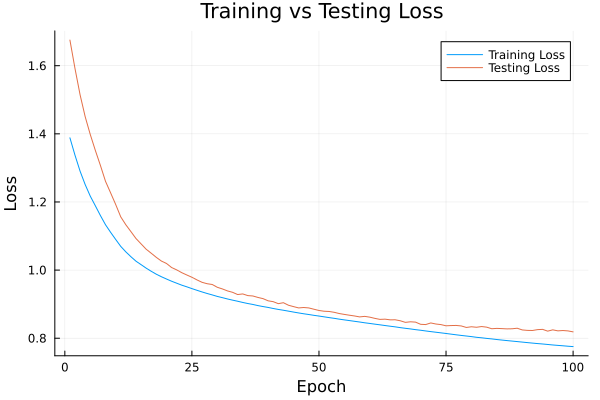

In [85]:

# Plot training and testing losses
plot(1:epochs, training_losses, label="Training Loss", xlabel="Epoch", ylabel="Loss", title="Training vs Testing Loss")
plot!(1:epochs, testing_losses, label="Testing Loss")

In [91]:
# println("Size of X_test: ", size(X_test))

model_input = Float32.(reshape(X_test[:, 1], :, 1))
model_output = model(model_input)
println(model_output)

# Evaluate the model on the test data
accuracy(x, y) = mean(Flux.onecold(model(x), 1:3) .== Flux.onecold(y, 1:3))
test_acc = accuracy(X_test, Y_test)
println("Test accuracy: $test_acc")




Float32[0.27768964; 0.10459475; 0.61771566;;]
Test accuracy: 0.6


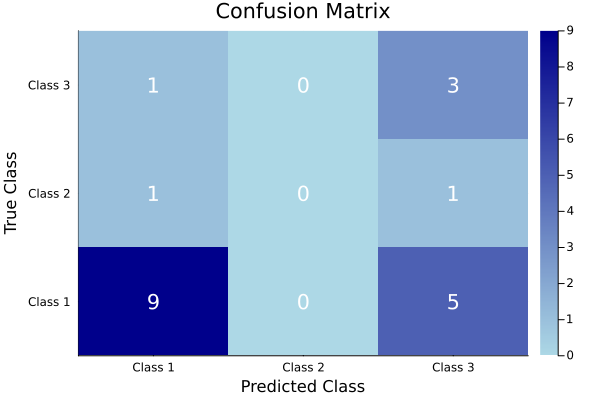

In [87]:
# Confusion matrix calculation as before
y_pred = Flux.onecold(model(X_test), 1:3)
y_true = Flux.onecold(Y_test, 1:3)
conf_matrix = confusmat(3, y_true, y_pred)

# Create a heatmap of the confusion matrix
heatmap_plt = heatmap(conf_matrix,
                      xticks=(1:3, ["Class 1", "Class 2", "Class 3"]),
                      yticks=(1:3, ["Class 1", "Class 2", "Class 3"]),
                      color=:blues,
                      xlabel="Predicted Class",
                      ylabel="True Class",
                      title="Confusion Matrix")

# Annotate the heatmap with the confusion matrix numbers
for i in 1:3
    for j in 1:3
        annotate!(j, i, Plots.text(conf_matrix[i, j], :center, :white))
    end
end

# Display the plot
display(heatmap_plt)



In [88]:
using LinearAlgebra

# Assume conf_matrix is already computed as shown previously
conf_matrix = confusmat(3, Flux.onecold(Y_test), Flux.onecold(model(X_test)))

# Function to calculate class-specific recall
function class_recall(cm, class)
    true_positives = cm[class, class]
    actual_positives = sum(cm[class, :])
    return actual_positives > 0 ? true_positives / actual_positives : 0.0
end

# Function to calculate class-specific precision
function class_precision(cm, class)
    true_positives = cm[class, class]
    predicted_positives = sum(cm[:, class])
    return predicted_positives > 0 ? true_positives / predicted_positives : 0.0
end

# Calculate overall accuracy by taking the trace of the confusion matrix and dividing by the total sum
accuracy_score = tr(conf_matrix) / sum(conf_matrix)

# Calculate recall and precision for each class
recall_scores = [class_recall(conf_matrix, i) for i in 1:size(conf_matrix, 1)]
precision_scores = [class_precision(conf_matrix, i) for i in 1:size(conf_matrix, 2)]

println("Accuracy: $accuracy_score")
println("Recall for each class: $recall_scores")
println("Precision for each class: $precision_scores")


Accuracy: 0.6
Recall for each class: [0.6428571428571429, 0.0, 0.75]
Precision for each class: [0.8181818181818182, 0.0, 0.3333333333333333]
